# Track the Voids
Determine which voids in each image are the same

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import convert_to_per_particle, compile_void_tracks, compute_drift
from pathlib import Path
import trackpy as tp
import pandas as pd
import numpy as np

Configuration

In [2]:
run_path = Path('../../runs/drift-corrected-625C/')

## Load in the defect information
The `rtdefects` command-line application generates a JSON file with the positions and sizes of each void detected in each frame.

Our first step is to load that JSON into memory

In [3]:
void_data = pd.read_json(run_path / 'frames/masks/defect-details.json', lines=True).sort_values("image-path", ignore_index=True)
void_data['frame'] = np.arange(len(void_data))
print(f'Loaded defects from {len(void_data)} frames')

Loaded defects from 339 frames


Save the processed version too

In [4]:
void_data.to_json(run_path / 'frame_data.json')

## Show that we've detected void growth
Without tracking individual voids, we can see that they are growing in size and number

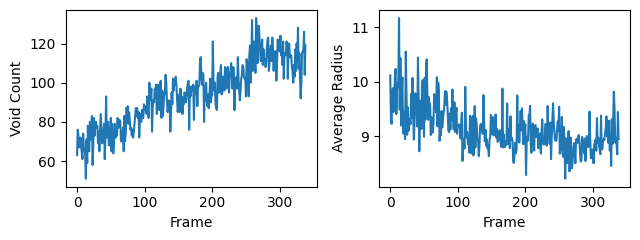

In [5]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(6.5, 2.5))

axs[0].plot(void_data.index, void_data['void_count'])
axs[0].set_ylabel('Void Count')

axs[1].plot(void_data.index, void_data['radii_average'])
axs[1].set_ylabel('Average Radius')

for ax in axs:
    ax.set_xlabel('Frame')
    
fig.tight_layout()

We can see that we are detecting at least a dozen void per frame. Both the number and size increase with time.

There are many frames at the end where we don't detect any defects. Let's eliminate thsoe from the analysis.

In [6]:
void_data.query('void_count > 0', inplace=True, )
print(f'Reduced to {len(void_data)} frames with at least 1 void.')

Reduced to 339 frames with at least 1 void.


## Remove drift and then re-detect voids
This video has the defects removed, so we can compute void displacement with ease

In [7]:
%%time
particles = pd.concat(list(convert_to_per_particle(void_data)))
initial_tracks = tp.link_df(particles, search_range=16, memory=16)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles')

Frame 338: 119 trajectories present.
Found a total of 939 unique particles
CPU times: total: 594 ms
Wall time: 1.62 s


Note how we fewer unique voids this time! Things that initially "moved" too far to detect because of the camera drift are now associated together.

In [8]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,25,26,23,"[[3.76271186440678, 745.3389830508474], [3.800...","[0, None, None, None, None, None, None, None, ...","[0.0, 0.04769655924279367, 0.09539311848558768...",2.695101,0.103658,"[0.0, 0.04769655924279367, 0.09539311848558768...",3.790152,0.145775,"[4.333622420659609, 4.32110957885937, 4.308596...",4.333622,4.145930,-0.012513
1,0,338,339,123,"[[493.65269461077844, 266.8922155688623], [492...","[34, 38, 41, 34, 34, 37, 32, None, None, None,...","[0.0, 1.233511326228913, 2.0486717211757415, 2...",17.745102,0.052345,"[0.0, 1.233511326228913, 2.2319189785822275, 3...",465.101293,1.371980,"[7.290936221960321, 6.231677632421503, 6.67558...",7.290936,3.989423,0.000141
2,0,338,339,0,"[[529.3502170767005, 650.6801736613603], [529....","[35, 39, 42, 35, 35, 39, 34, 35, 31, 36, 35, 3...","[0.0, 0.3232884173724153, 0.5621338615533008, ...",2.951186,0.008706,"[0.0, 0.3232884173724153, 0.5928811574011023, ...",268.091302,0.790830,"[14.830783234644061, 15.086138293858053, 15.40...",21.930942,14.830783,0.017869
3,0,338,339,117,"[[534.2560975609756, 988.780487804878], [534.1...","[36, 41, None, None, None, None, 35, None, Non...","[0.0, 0.16491907591475458, 0.3602310386361187,...",7.786887,0.022970,"[0.0, 0.16491907591475458, 0.3602320684449002,...",303.891395,0.896435,"[5.108953969950291, 5.411516379806009, 5.31936...",7.046726,4.068429,0.001697
4,0,338,339,0,"[[590.5560916767189, 171.6037394451146], [591....","[37, 44, 44, 38, 37, 41, 39, 37, 34, 39, 37, 3...","[0.0, 1.1375762197095738, 0.8821273682991589, ...",1.962989,0.005791,"[0.0, 1.1375762197095738, 2.0359433438026455, ...",257.535909,0.759693,"[22.9729795910919, 23.13177292545801, 23.04906...",27.960134,22.659079,0.014373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,337,337,1,0,"[[609.56, 61.86]]",[64],NaN,NaN,NaN,NaN,NaN,NaN,[3.989422804014327],3.989423,3.989423,NaN
935,337,337,1,0,"[[167.0, 805.8730158730159]]",[17],NaN,NaN,NaN,NaN,NaN,NaN,[4.478115991081385],4.478116,4.478116,NaN
936,338,338,1,0,"[[534.2089552238806, 430.9850746268657]]",[68],NaN,NaN,NaN,NaN,NaN,NaN,[4.61809077155419],4.618091,4.618091,NaN
937,338,338,1,0,"[[895.2727272727273, 231.61363636363637]]",[112],NaN,NaN,NaN,NaN,NaN,NaN,[5.292567428401227],5.292567,5.292567,NaN


In [9]:
void_tracks.to_json(run_path / 'void_tracks.json')

In [10]:
void_tracks.loc[0]

start_frame                                                        0
end_frame                                                         25
total_frames                                                      26
inferred_frames                                                   23
positions          [[3.76271186440678, 745.3389830508474], [3.800...
local_id           [0, None, None, None, None, None, None, None, ...
disp_from_start    [0.0, 0.04769655924279367, 0.09539311848558768...
max_disp                                                    2.695101
drift_rate                                                  0.103658
dist_traveled      [0.0, 0.04769655924279367, 0.09539311848558768...
total_traveled                                              3.790152
movement_rate                                               0.145775
radii              [4.333622420659609, 4.32110957885937, 4.308596...
max_radius                                                  4.333622
min_radius                        